In [56]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)

In [57]:
#Reading in Data
df = pd.read_csv('data/da_js_coding_challenge.csv')

df.sample(5)

,channel_id,stats_date,channel_view_count,channel_subscriber_count,channel_video_count
1846181,UCOR5w7ZqA0u7Z7LCqj0nnwA,2020-03-01,11559581,45800.0,677
243690,UC-B4C2ZSA0NVW5E5NSYLh6A,2020-03-01,123333770,652000.0,273
418725,UC2OBrAxbgGV4lxrIiWUr3Ag,2019-10-01,8483727,423000.0,83
108699,UC1uq_GHtFPL6MrJZBU4LnsQ,2019-12-01,50523501,118000.0,4075
4636725,UCzYtcjWukXAw8vLPor_jOvw,2020-03-01,2009431,6930.0,54


 #### 1. Data Cleaning



* ##### a. Describe the dataset (here we are expecting a comprehensive statistical description)

In [58]:
#Describe dataset
df.describe()

,channel_view_count,channel_subscriber_count,channel_video_count
count,5.240017e+06,5.172437e+06,5.240017e+06
mean,5.209417e+07,2.022722e+05,5.934202e+02
std,4.380357e+08,9.450692e+05,4.600393e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.856370e+06,1.660000e+04,5.100000e+01
50%,5.799039e+06,3.690000e+04,1.430000e+02
75%,1.966140e+07,1.156900e+05,3.740000e+02
max,1.261330e+11,1.550000e+08,1.067410e+06


In [59]:
print(
    f"""
    Total Views: {df.channel_view_count.sum()}
    Median Views: {df.channel_view_count.median()}
    
    Total Subscribers: {df.channel_subscriber_count.sum()}
    Median Subscribers: {df.channel_subscriber_count.median()}
    
    Total Videos: {df.channel_video_count.sum()}
    Median Videos: {df.channel_video_count.median()}
    """
)




    Total Views: 272974327831600
    Median Views: 5799039.0
    
    Total Subscribers: 1046240425734.0
    Median Subscribers: 36900.0
    
    Total Videos: 3109532122
    Median Videos: 143.0
    


* ##### b. Handle the Null values

Approach: (channel_view_count) / (channel_view_count/ channel_video_count squared)

In [60]:
#Handle Nulls within the datasets 
df.isnull().any() #--> Subscribers have a ton of nulls. Let's clean it up.

channel_id                  False
stats_date                  False
channel_view_count          False
channel_subscriber_count     True
channel_video_count         False
dtype: bool

In [61]:


def subs_null_count(record):
    view, subs, video = record['channel_view_count'], record['channel_subscriber_count'], record['channel_video_count']
    if pd.isna(subs):
        if view < 1 or video < 1:
            #mean of all susbscriber within the data / number of months (3 years = 36 months)
            return df.channel_subscriber_count.mean()/36
        else:
            return view / (view / video ** 2 )
        
#Dividing the datasets based on null field 
no_missing_data = df[pd.notna(df.channel_subscriber_count)]
missing_data = df[pd.isna(df.channel_subscriber_count)]

missing_data['channel_subscriber_count'] = missing_data.apply(subs_null_count, axis= 1)

/var/folders/2c/j7j4c5v52mqd312q_kq3gpl00000gn/T/ipykernel_2790/1060246997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['channel_subscriber_count'] = missing_data.apply(subs_null_count, axis= 1)


In [62]:
df = pd.concat([no_missing_data, missing_data])
missing_data.isnull().any()

channel_id                  False
stats_date                  False
channel_view_count          False
channel_subscriber_count    False
channel_video_count         False
dtype: bool

In [63]:
# formatting all data types
df['channel_id'] = df['channel_id'].astype(str)
df['stats_date'] = pd.to_datetime(df['stats_date'])
df['channel_view_count'] = df['channel_view_count'].astype(int)
df['channel_subscriber_count'] = df['channel_subscriber_count'].apply(lambda x: int(float(x)))
df['channel_view_count'] = df['channel_view_count'].astype(int)

df.dtypes

channel_id                          object
stats_date                  datetime64[ns]
channel_view_count                   int64
channel_subscriber_count             int64
channel_video_count                  int64
dtype: object

* ##### c. There are missing data for several channels (a gap of 1 to several months between two stats for the same channel), handle the gaps

In [64]:
#Let's see the minimum and maximum dates
print(
    f"""
    ***************** DATA SUMMARY *****************
      * Minimum Date: {df.stats_date.dt.date.min()}
      * Maximum Date: {df.stats_date.dt.date.max()}
    ************************************************
    """
)


    ***************** DATA SUMMARY *****************
      * Minimum Date: 2019-09-01
      * Maximum Date: 2020-10-01
    ************************************************
    


###### This observation shows that we actually dont have 3 years worth of data. We do have a couple months of data but we can definately place in a month of two data. This method will be use be verfying few points. 

* 1. Calculate the overall mean per each quantitative field
* 2. Calaculate the mean and max of each month year data. 

###### Decision Marker: If overall mean is greater than the monthly mean then; compare the overall mean to the max of that month

###### Despite this, It's best not to fill in the gaps since we werent provided the daily records within each month so theere isn't a best way to remedy this without having dialy data. 

In [65]:
channel_df = df.channel_id.value_counts().reset_index()
channel_df

,index,channel_id
0,UC9WiXJEyHMGRqL-__3FIBEw,14
1,UCy5FUarBYUHFpPtYVuvzgcA,14
2,UCIvaYmXn910QMdemBG3v1pQ,14
3,UCnIutYBFG6Zd0WDZlGX3r6g,14
4,UCyfZleh4w7buTzi0WfY8WqA,14
...,...,...
577176,UCYCNWzdK_343x8jktTRJlKw,1
577177,UCi6MeQ2aqLbIJ-mTbxMceCA,1
577178,UCYIbhJQlqCIp30UC-rQHbpA,1
577179,UC68jRyC8uFsshGK6Ot1qxOQ,1


In [66]:
df.columns

Index(['channel_id', 'stats_date', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count'],
      dtype='object')

In [67]:
ans = df.groupby(['stats_date']).agg(
    {'channel_view_count': 'mean', 
     'channel_subscriber_count': 'mean',
     'channel_video_count' : 'mean'}).reset_index()

ans['channel_view_count'] = ans['channel_view_count']- df.channel_subscriber_count.mean()
ans

,stats_date,channel_view_count,channel_subscriber_count,channel_video_count
0,2019-09-01,5.677363e+07,262396.004705,665.796352
1,2019-10-01,5.902718e+07,285702.942991,677.124631
2,2019-11-01,9.430305e+07,437026.101678,830.633284
3,2019-12-01,4.730484e+07,314852.829338,591.367768
4,2020-01-01,4.818048e+07,251991.003665,593.007157
5,2020-02-01,4.954145e+07,245748.866153,589.808125
6,2020-03-01,5.071528e+07,252774.811384,591.833147
7,2020-04-01,6.942323e+07,324542.685918,641.380004
8,2020-05-01,4.879892e+07,226456.536816,583.632966
9,2020-06-01,4.847976e+07,219629.892574,575.852330


In [68]:
df.sample(5)

,channel_id,stats_date,channel_view_count,channel_subscriber_count,channel_video_count
3542595,UCdTZsE3OcOEglvIcHFFPjhg,2020-03-01,5269004,36600,85
5067725,UCyFvgxMxDrVTouHBvkIw9Rw,2020-05-01,11421075,509000,397
4114867,UCqdlkI3mV3Ykw7IlKR9dwCA,2020-09-01,46159880,99200,95
1183390,UC9_c_Xk_gCNu02feILK_JOg,2020-09-01,14588462,338000,1202
1128347,UCD4aO2FOB35gLHIDqc8WQfg,2019-11-01,3611570,13900,77


In [69]:
df.set_index(['channel_id', 'stats_date']).interpolate()

channel_view_count  \
channel_id               stats_date                       
UC---lM1j0uNzsFxF0V2IZnw 2020-09-01              552376   
                         2020-10-01              554531   
UC--0iabXc55NqDGIR190lHg 2019-12-01             2744868   
                         2020-01-01             1654366   
                         2020-02-01             1827834   
...                                                 ...   
UCzp0FaKw2gUVw6e8DtzXsSw 2020-05-01             2877050   
                         2020-06-01             2958737   
UCzuVkVaOixLB6KNxx1B2a5w 2019-09-01               55702   
                         2019-10-01               65189   
                         2019-11-01               78115   

                                     channel_subscriber_count  \
channel_id               stats_date                             
UC---lM1j0uNzsFxF0V2IZnw 2020-09-01                     11100   
                         2020-10-01                     11100   
UC--0iabXc55NqDGIR190lHg 2019-12-01                     15900   
                         2020-01-01                     17500   
                         2020-02-01                     18400   
...                                                       ...   
UCzp0FaKw2gUVw6e8DtzXsSw 2020-05-01                      2116   
                         2020-06-01                      2304   
UCzuVkVaOixLB6KNxx1B2a5w 2019-09-01                      1521   
                         2019-10-01                      2116   
                         2019-11-01                      2304   

                                     channel_video_count  
channel_id               stats_date                       
UC---lM1j0uNzsFxF0V2IZnw 2020-09-01                   16  
                         2020-10-01                   16  
UC--0iabXc55NqDGIR190lHg 2019-12-01                   22  
                         2020-01-01                   35  
                         2020-02-01                   51  
...                                                  ...  
UCzp0FaKw2gUVw6e8DtzXsSw 2020-05-01                   46  
                         2020-06-01                   48  
UCzuVkVaOixLB6KNxx1B2a5w 2019-09-01                   39  
                         2019-10-01                   46  
                         2019-11-01                   48  

[5240017 rows x 3 columns]

### Data Transformation 

 * 1. monthy_subscribers (how many subscribers the channel added on a given month)
 * 2. monthly_views_avg_3month (3 month rolling average for the monthly views)
 * 3. 6months_publications (6 month rolling sum of video publications)

### Add the following categorical metrics:

    i. Assign:
        1. "V50k" for the channels that generate less than 50k monthly views on the last three months
        2. "V200k" for the channels that generate less than 200k but more than 50k monthly views on the last three months
        3. "V1M" for the channels that generate less than 1M but more than 200k monthly views on the last three months
        4. "V10M" for the channels that generate less than 10M but more than 1M monthly views on the last three months
        5. "V10M+" otherwise
    
    ii. Assign:
        1. "S100k" for the channels that have less than 100k subscribers the last month
        2. "S1M" for the channels that have less than 1M but more than 100k subscribers the last month
        3. "S10M" for the channels that have less than 10M but more than 1M subscribers the last month
        4. "S10M+" otherwise



In [70]:
df.sort_values(['channel_id', 'stats_date'], inplace=True)

In [71]:
def getMonth(x):
    if int(x) in range(50000):
        return 'V50K'
    elif int(x) in range(50000, 200000):
        return 'V200K'
    elif int(x) in range(200000, 1000000):
        return 'V1M'
    elif int(x) in range(1000000, 10000000):
        return 'V10M'
    else:
        return 'V10M+'

def getSubs(x):
    
    if int(x) in range(100000):
        return 'S100K'
    elif int(x) in range(100000, 1000000):
        return 'S1M'
    elif int(x) in range(1000000, 10000000):
        return 'S10M'
    else:
        return 'S10M+'

In [72]:
# monthly_subscribers (how many subscribers the channel added on a given month)
df['monthly_subscribers'] = df.groupby('channel_id')['channel_subscriber_count'].diff().reset_index(
    drop=True).fillna(df.channel_subscriber_count)

# Adding categorical variables to the monthly sucbribers attributes 
df.monthly_subscribers = df.monthly_subscribers.apply(getSubs)
df.monthly_subscribers = df.monthly_subscribers.astype('category').cat.set_categories(['S100K', 'S1M', 'S10M', 'S10M+'])

In [73]:
# monthly_views_avg_3month (3 month rolling average for the monthly views)
df['monthly_views_avg_3month'] = df.groupby('channel_id').rolling(3)['channel_view_count'].mean().reset_index(
    drop=True).fillna(df.channel_view_count)

# Adding categorical variables to the monthly sucbribers attributes 
df.monthly_views_avg_3month = df.monthly_views_avg_3month.apply(getMonth)
df.monthly_views_avg_3month = df.monthly_views_avg_3month.astype('category').cat.set_categories([ 'V50K', 'V200K', 'V1M', 'V10M', 'V10M+'])

In [74]:
#6months_publications (6 month rolling sum of video publications)
df['months_publications'] = df.groupby('channel_id').rolling(6)['channel_video_count'].sum().reset_index(
    drop=True).fillna(df.channel_video_count)

# Adding categorical variables 
df.months_publications = df.months_publications.apply(getSubs)
df.months_publications = df.months_publications.astype('category').cat.set_categories(['S100K', 'S1M', 'S10M', 'S10M+'])

Simple Findings 

In [75]:
#Channel Counts
df.channel_id.value_counts()

UCrDhzEPsAIrUxJ6Dv3oyjjQ    14
UC0BvmQ-UWDnDc9seBcSanRA    14
UClBmbsqZ1mf40dp2UD_2m5g    14
UCFTtrxmEhd1pu-_ShK8XeIg    14
UCQ3f3-mbAPLsclSYKwLUuCg    14
                            ..
UC9JOaF8BWP0WTAHhZVCksMg     1
UC8RMiXtAP2yQFg6fz_Zg14Q     1
UCWPkiADgITw4_WnAfk3pffA     1
UCZVS7cIrsCWWhztiXc_nIew     1
UCjnq3F5IUgRMFlkdNVELHFA     1
Name: channel_id, Length: 577181, dtype: int64

In [76]:
#Distribution of subscribers
df[['channel_subscriber_count']].describe()

,channel_subscriber_count
count,5.240017e+06
mean,2.427955e+05
std,1.596746e+07
min,0.000000e+00
25%,1.640000e+04
50%,3.660000e+04
75%,1.150000e+05
max,2.755069e+10


In [77]:
# channel view info
df[['channel_view_count']].describe()

,channel_view_count
count,5.240017e+06
mean,5.209417e+07
std,4.380357e+08
min,0.000000e+00
25%,1.856370e+06
50%,5.799039e+06
75%,1.966140e+07
max,1.261330e+11


In [78]:
# channel video info
df[['channel_video_count']].describe()

,channel_video_count
count,5.240017e+06
mean,5.934202e+02
std,4.600393e+03
min,0.000000e+00
25%,5.100000e+01
50%,1.430000e+02
75%,3.740000e+02
max,1.067410e+06


In [79]:
df.monthly_subscribers.value_counts()

S100K    4517216
S10M+     508260
S1M       192497
S10M       22044
Name: monthly_subscribers, dtype: int64

In [80]:
df.monthly_views_avg_3month.value_counts()

V10M     2454979
V10M+    2013893
V1M       521092
V50K      130855
V200K     119198
Name: monthly_views_avg_3month, dtype: int64

In [81]:
df.months_publications.value_counts()

S100K    5228662
S1M        11118
S10M         237
S10M+          0
Name: months_publications, dtype: int64

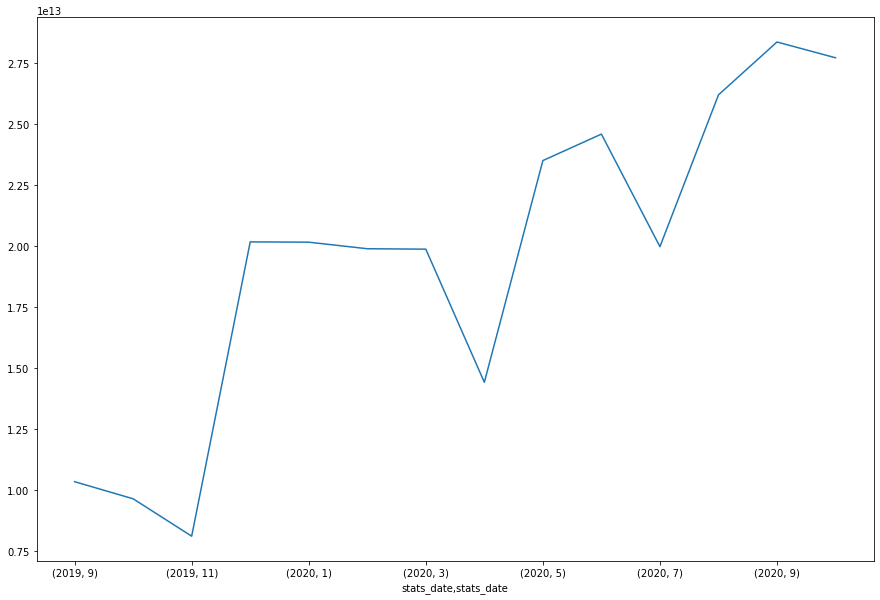

In [82]:
#Lets see the trends per month-year
_ = df.groupby([df.stats_date.dt.year, df.stats_date.dt.month])['channel_view_count'].sum().plot()


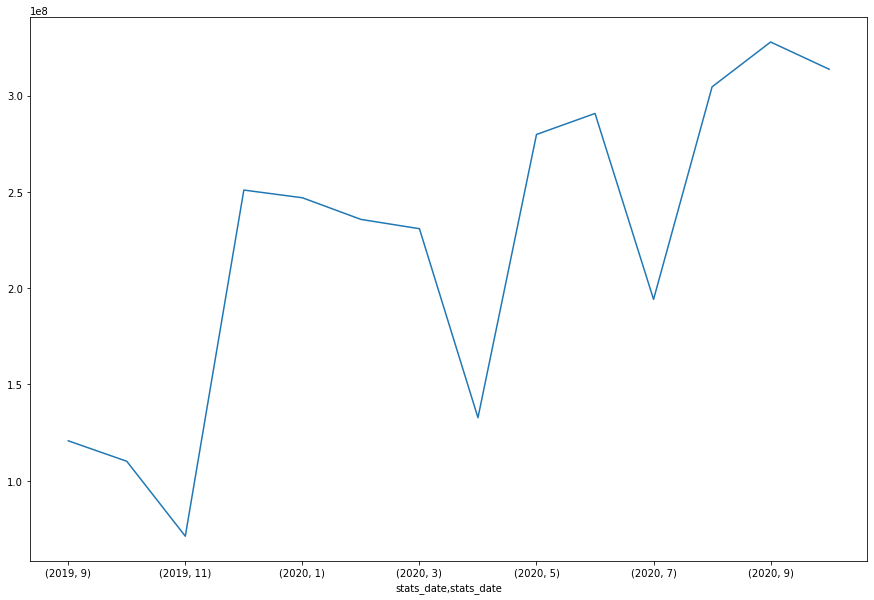

In [83]:
_ = df.groupby([df.stats_date.dt.year, df.stats_date.dt.month])['channel_video_count'].sum().plot()

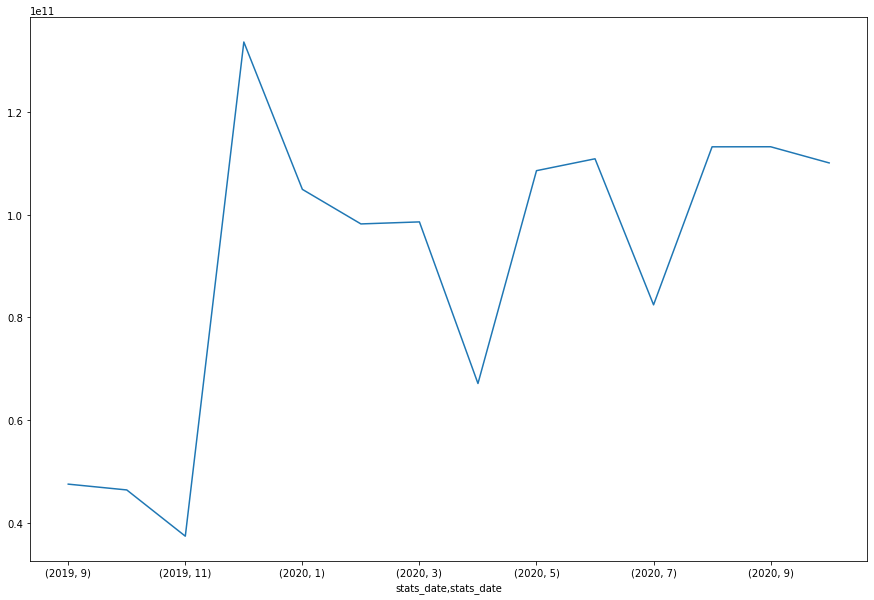

In [84]:
_ = df.groupby([df.stats_date.dt.year, df.stats_date.dt.month])['channel_subscriber_count'].sum().plot()

Observations: 

* 1. Most channels have a more subscribers at the end of 2019 but have fewer views as videos. This shows that are multiple channels whose subscribers are either joining and viewing old videos, or just joined and not really intrested in the channels content 

* 2. Content creaters tend to create more vidoes when they start losing subscribers. This shows glaring sign of creators not paying attention to the subcriber base.

Plot the median monthly views of the channels that have more than 1M subscribers as of current month in 2020 which generated less than 10M views on average in the last 3 months

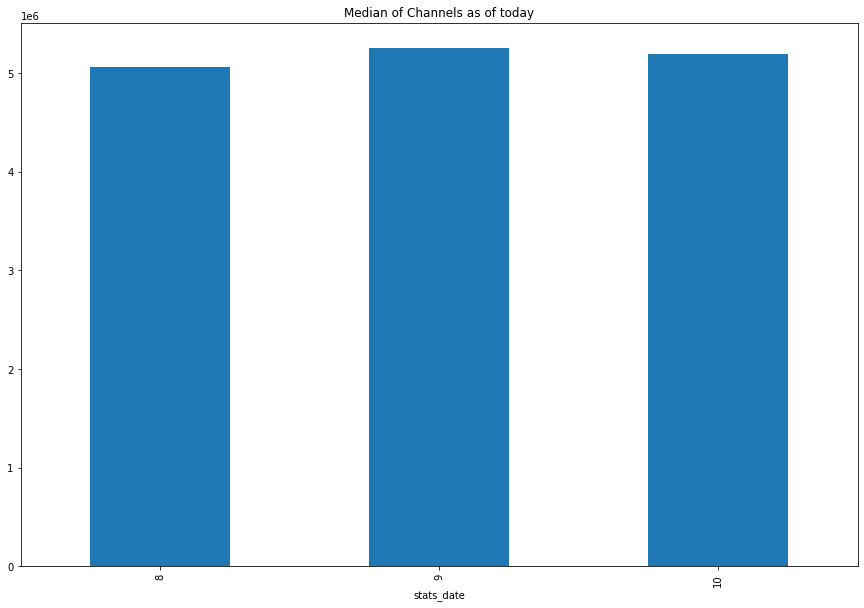

In [85]:
#Dynamic Approach
todays_date = dt.datetime.now()
three_month_date = todays_date - dt.timedelta(days=90)

#three Months data up to today's month in 2020
data = df[(df.stats_date.dt.month > three_month_date.month) & 
          (df.stats_date.dt.month <= todays_date.month) & (df.stats_date.dt.year == 2020)]

#channels with more than 1M subcriber as of the current month
channels = data.loc[(data.monthly_subscribers.isin(['S10M', 'S10M+'])) 
                    & (df.stats_date.dt.month <= todays_date.month), :]

#See if those channels have less than 10M views on average 
ans = channels[~channels['monthly_views_avg_3month'].isin(['V10M','V10M+'])]
graph = ans.groupby(df.stats_date.dt.month)['channel_view_count'].median().plot(kind='bar')#ans.groupby('channel_id')['channel_view_count'].median().plot()
graph.set_title('Median of Channels as of today')
plt.show()

What is the average views generated each month per viewership group?

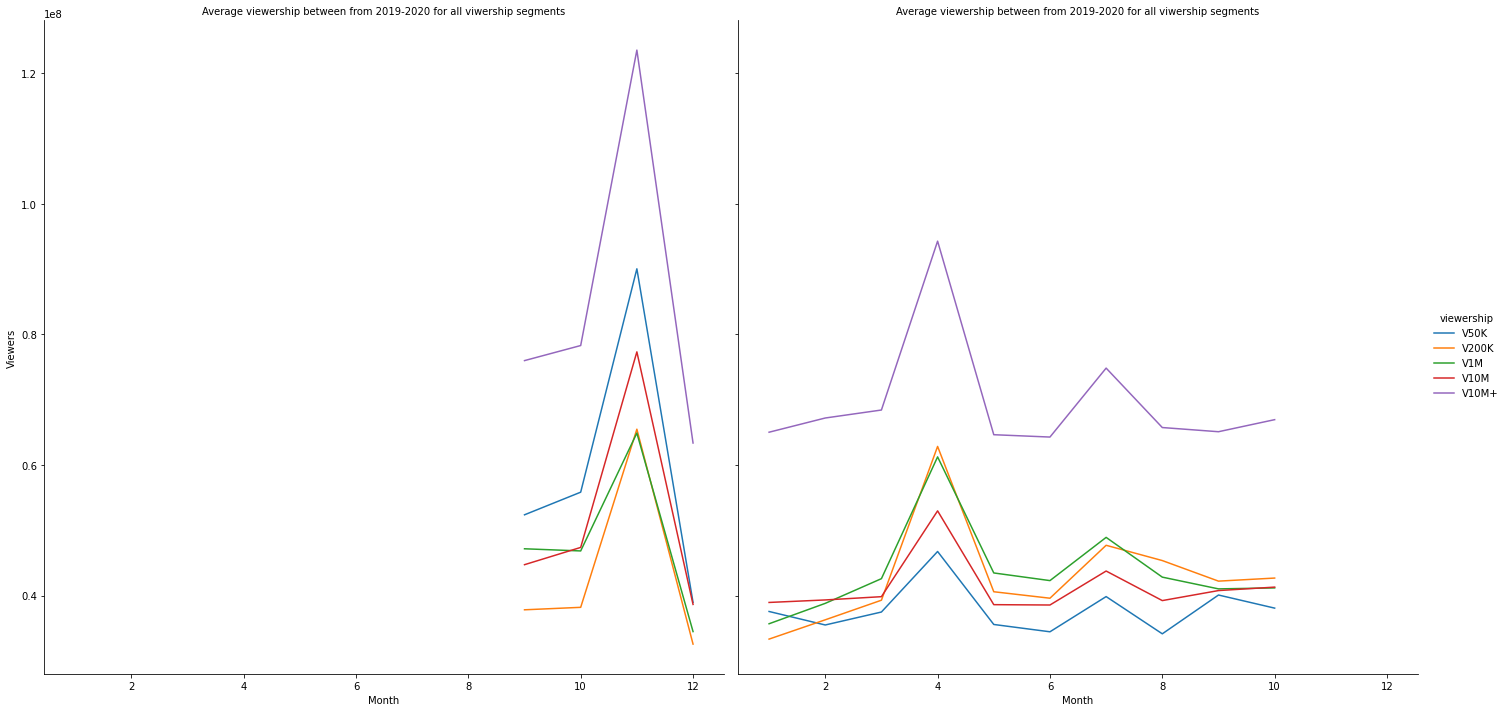

In [86]:

df['year'] = df.stats_date.dt.year
df['month'] = df.stats_date.dt.month
data = df.groupby(['monthly_views_avg_3month', 'year', 'month']).agg(
    {'channel_view_count': 'mean'}).reset_index().rename(columns={'monthly_views_avg_3month':'viewership'})


g = sns.FacetGrid(data, col='year', height= 10, hue='viewership' )
g.map(sns.lineplot, 'month', 'channel_view_count')
g.add_legend()
g.set_axis_labels(x_var='Month', y_var='Viewers')
g.set_titles('Average viewership between from 2019-2020 for all viwership segments')
plt.show()

By Month, which year has the best viewership count with over a million monthly subscriber? 

In [87]:
df.monthly_subscribers.unique()

['S100K', 'S10M+', 'S1M', 'S10M']
Categories (4, object): ['S100K', 'S1M', 'S10M', 'S10M+']

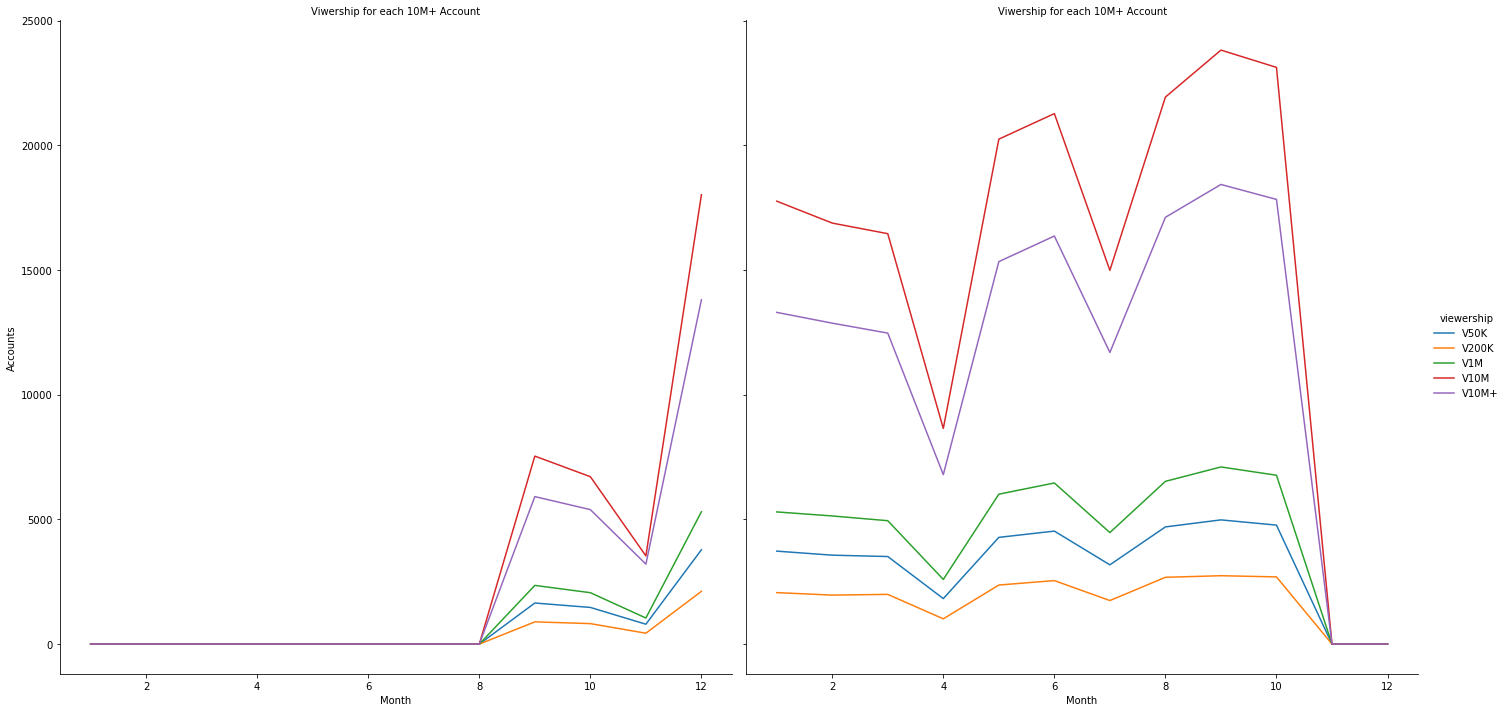

In [88]:
data = df[df['monthly_subscribers'].str.contains('S10M')]
ans = data.groupby(['year', 'month', 'monthly_views_avg_3month']).agg(
    {'channel_id' : 'count'}).reset_index().rename(columns={'monthly_views_avg_3month':'viewership', 'channel_id':'accounts'})

g = sns.FacetGrid(ans, col='year', height= 10, hue='viewership' )
g.map(sns.lineplot, 'month', 'accounts')
g.set_axis_labels(x_var='Month', y_var='Accounts')
g.set_titles('Viwership for each 10M+ Account')
g.add_legend()
plt.show()

How many channels had a 10M+ in a 6 months publication window from April to August of 2020?

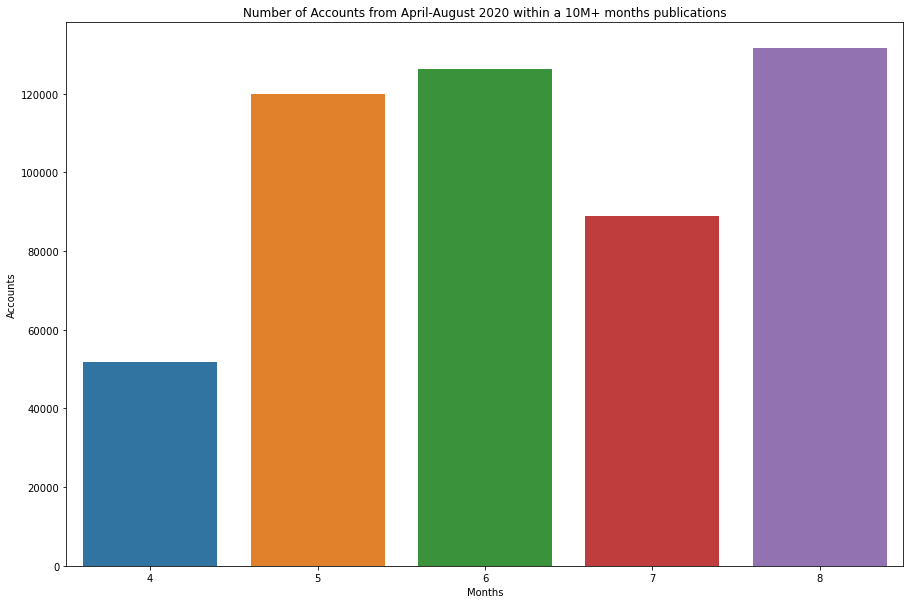

In [89]:
data = df[df['year'] == 2020]
ans = data.loc[(df['month'] >= 4) & (df['month'] <= 8), ['channel_id', 'months_publications', 'month']]

ans = ans.groupby(['month', 'months_publications']).count().reset_index()
sns.barplot(data=ans, x='month', y= 'channel_id', ci=None)
plt.xlabel('Months')
plt.ylabel('Accounts')
plt.title('Number of Accounts from April-August 2020 within a 10M+ months publications')
plt.show()

With channels averaging 10M+ views per each 3 month period, what's the average video count per each subscriber group?

In [90]:
df.monthly_views_avg_3month.unique()

['V10M+', 'V200K', 'V1M', 'V10M', 'V50K']
Categories (5, object): ['V50K', 'V200K', 'V1M', 'V10M', 'V10M+']

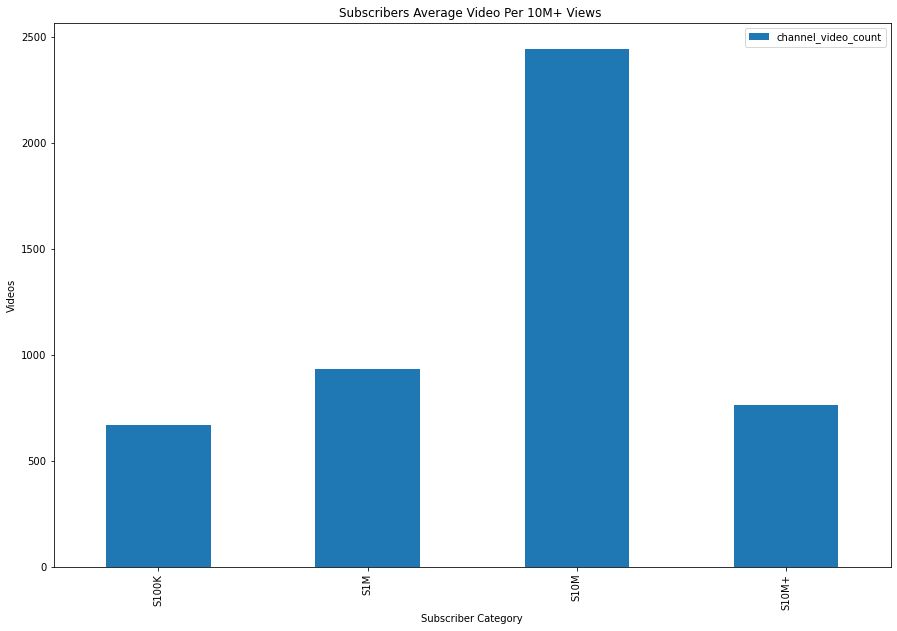

In [91]:
df[df['monthly_views_avg_3month'] == 'V10M+'].groupby('monthly_subscribers').agg(
    {'channel_video_count':'mean'}).plot(kind='bar')

plt.title('Subscribers Average Video Per 10M+ Views ')
plt.xlabel('Subscriber Category')
plt.ylabel('Videos')
plt.show()

Does the moving average tell us which subscriber group is benefiting per month from October 2019-October 2020?

In [106]:
data = df[(df.stats_date >= '2019-10-01') & (df.stats_date < '2020-11-01')]
ans = data.groupby(['stats_date', 'monthly_subscribers']).agg({'channel_id': 'nunique'}).reset_index()

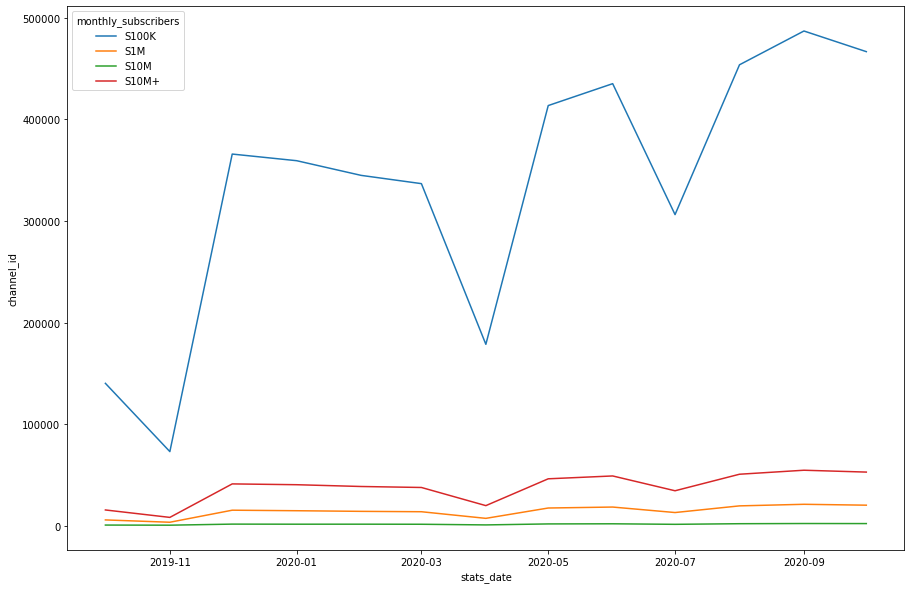

In [107]:
sns.lineplot(data=ans, x='stats_date', y='channel_id', hue='monthly_subscribers')
plt.show()

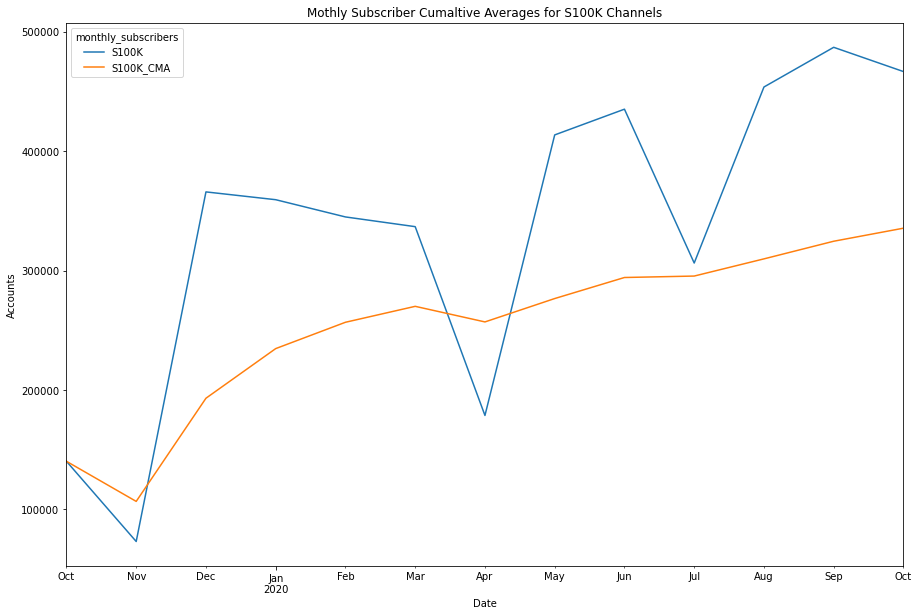

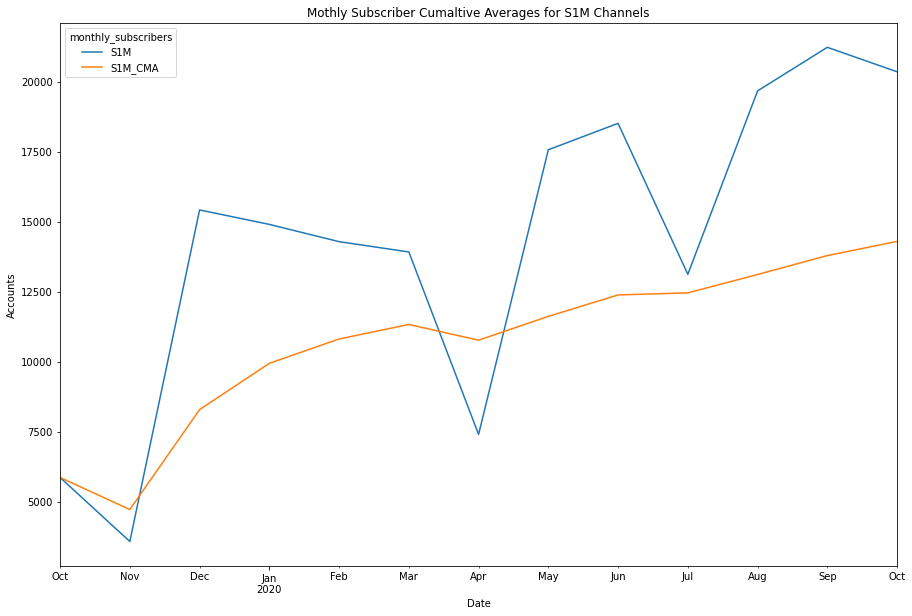

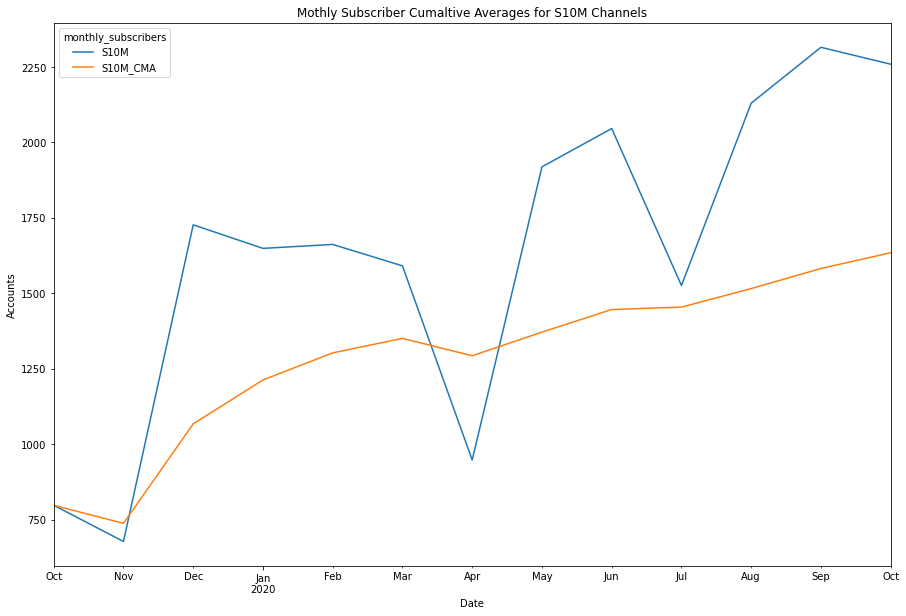

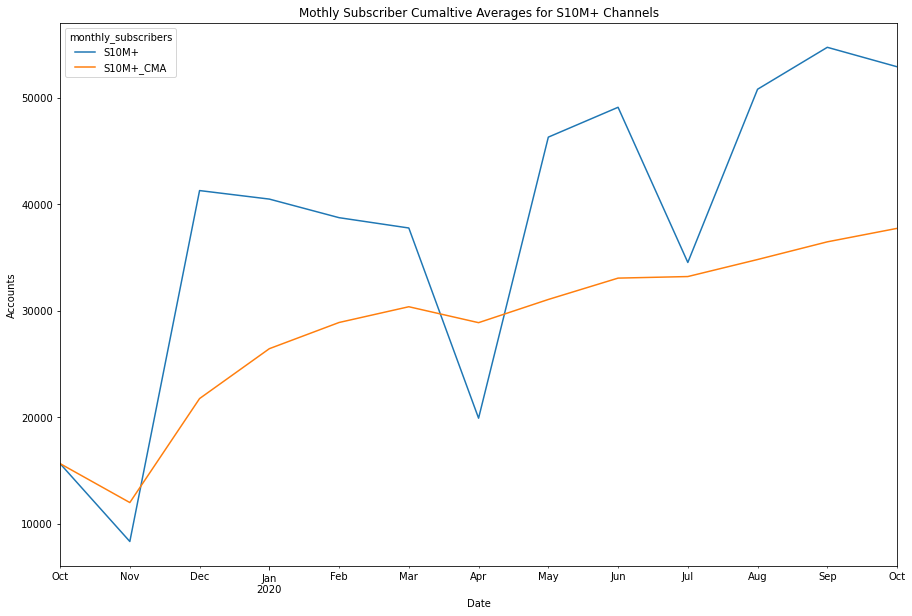

In [108]:
ans = ans.pivot(index='stats_date', columns='monthly_subscribers', values='channel_id').reset_index()
ans = ans.set_index('stats_date')
for col_name in ans.columns:
    if 'S' in col_name:
        ans[f'{col_name}_CMA'] = ans[col_name].expanding().mean()
        ans[[col_name, f'{col_name}_CMA']].plot()
        plt.xlabel('Date')
        plt.ylabel('Accounts')
        plt.title(f'Mothly Subscriber Cumaltive Averages for {col_name} Channels')
        plt.show()